# Language Conditioned Robot Skills (LCRS) - Live Demo

## Load the pre-trained model

In [1]:
from calvin_agent.utils.utils import print_system_env_info, get_last_checkpoint, format_sftp_path
from pytorch_lightning import Callback, LightningModule, seed_everything, Trainer
from omegaconf import DictConfig, OmegaConf
from pytorch_lightning.utilities.cloud_io import load as pl_load
from hydra.utils import instantiate
from hydra import initialize, compose
from pathlib import Path
import sys
from typing import List
import lcrs
import time
import numpy as np
from matplotlib import pyplot as plt
from enum import Enum
import os
import torch
from torchvision.transforms import Normalize 
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

#import logging
#from lcrs.utils.distribution import Distribution
#from hydra import initialize, initialize_config_module, initialize_config_dir, compose
#import hydra
#from pytorch_lightning.utilities import rank_zero_only
#from pytorch_lightning.loggers import Logger
#from pytorch_lightning.callbacks import LearningRateMonitor

/opt/conda/envs/lcrs_venv/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
class Dataset(Enum):
    D = "dataset/task_D_D"
    ABC = "dataset/task_ABC_D"
    ABCD = "dataset/task_ABCD_D"
    debug = "dataset/calvin_debug_dataset"
    
shm = ["vision_lang", "vision_lang_shm"]

In [3]:
#==================================================
# SELECT DATASET YOU WANT TO USE FOR DEMO HERE
#==================================================
selectedDataset = Dataset.debug
#useSharedMemory = False
model_checkpoint_path = "~/runs/2024-03-07/21-32-22/saved_models/epoch=0.ckpt"

In [4]:

import pathlib
#result = pathlib.Path(__file__).parent.resolve()
EMBEDDING_PATH = f"{os.getcwd()}/{selectedDataset.value}/validation/lang_annotations/embeddings.npy"
print(EMBEDDING_PATH)

with initialize(config_path="./conf"):
    cfg = compose(config_name="config", overrides=[f"datamodule.root_data_dir={selectedDataset.value}"])
    
seed_everything(cfg.seed, workers=True)

datamodule = instantiate(cfg.datamodule, training_repo_root=Path(lcrs.__file__).parents[1])
model = instantiate(cfg.model)
model = model.to(device)
#chk = get_last_checkpoint(Path("~/runs/2024-03-07/21-32-22"))
chk = Path(model_checkpoint_path)

if chk:
    #pretrain_chk = pl_load(format_sftp_path(Path(cfg.pretrain_chk)), map_location=lambda storage, loc: storage)
    pretrain_chk = pl_load(format_sftp_path(chk), map_location=lambda storage, loc: storage)
    model.load_state_dict(pretrain_chk["state_dict"], strict=False)
    print("LOADED PRE-TRAINED MODEL")
else:
    raise(Exception("No pre-trained model found"))

/home/jovyan/lcrs/dataset/calvin_debug_dataset/validation/lang_annotations/embeddings.npy


Global seed set to 42
/opt/conda/envs/lcrs_venv/lib/python3.10/site-packages/pytorch_lightning/utilities/cloud_io.py:41: LightningDeprecationWarning: `pytorch_lightning.utilities.cloud_io.load` has been deprecated in v1.8.0 and will be removed in v1.10.0. This function is internal but you can copy over its implementation.
  rank_zero_deprecation(


LOADED PRE-TRAINED MODEL


## Setup simulation environment

CALVIN

In [5]:
# Run this to check if the installation was succesful
from calvin_env.envs.play_table_env import PlayTableSimEnv

pybullet build time: Nov 28 2023 23:45:17


In [6]:
with initialize(config_path="./calvin/calvin_env/conf/"):
  env_cfg = compose(config_name="config_data_collection.yaml", overrides=["cameras=static_and_gripper"])
  env_cfg.env["use_egl"] = False
  env_cfg.env["show_gui"] = False
  env_cfg.env["use_vr"] = False
  env_cfg.env["use_scene_info"] = True
  print(env_cfg.env)

{'_target_': 'calvin_env.envs.play_table_env.PlayTableSimEnv', '_recursive_': False, 'cameras': '${cameras}', 'seed': 0, 'bullet_time_step': 240.0, 'use_vr': False, 'show_gui': False, 'robot_cfg': '${robot}', 'scene_cfg': '${scene}', 'use_scene_info': True, 'use_egl': False, 'control_freq': 30}


/opt/conda/envs/lcrs_venv/lib/python3.10/site-packages/hydra/_internal/defaults_list.py:251: UserWarning: In 'config_data_collection.yaml': Defaults list is missing `_self_`. See https://hydra.cc/docs/upgrades/1.0_to_1.1/default_composition_order for more information
  warnings.warn(msg, UserWarning)
/opt/conda/envs/lcrs_venv/lib/python3.10/site-packages/hydra/core/default_element.py:122: UserWarning: In 'vr_input/vr_controller/vive': Usage of deprecated keyword in package header '# @package _group_'.
See https://hydra.cc/docs/next/upgrades/1.0_to_1.1/changes_to_package_header for more information
  deprecation_warning(


dict_keys(['rgb_obs', 'depth_obs', 'robot_obs', 'scene_obs'])


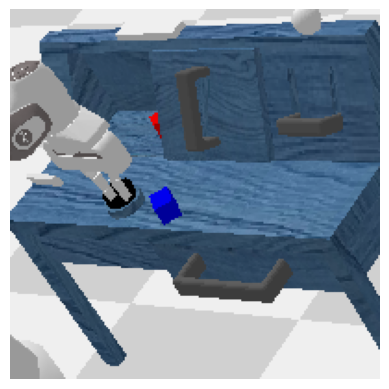

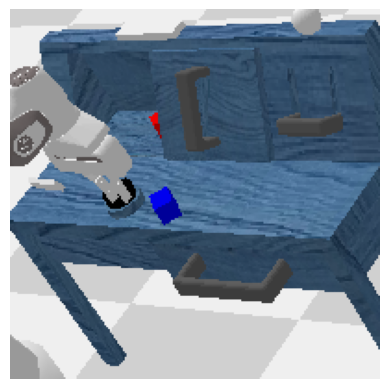

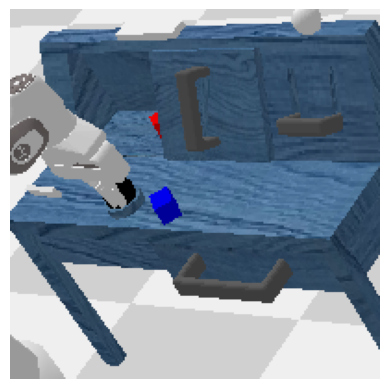

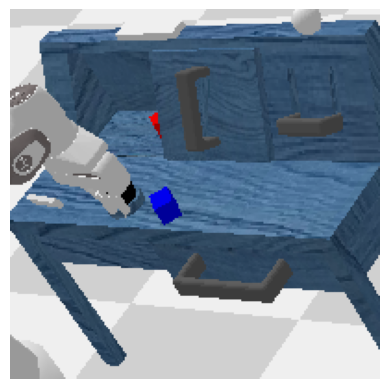

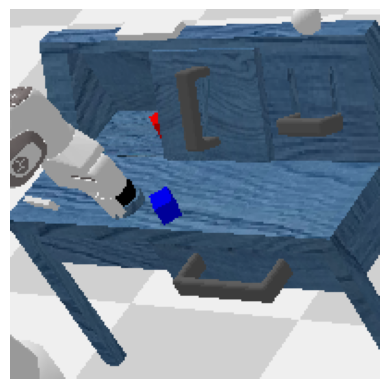

In [7]:
env = instantiate(env_cfg.env)
observation = env.reset()
#The observation is given as a dictionary with different values
print(observation.keys())
for i in range(5):
  # The action consists in a pose displacement (position and orientation)
  action_displacement = np.random.uniform(low=-1, high=1, size=6)
  # And a binary gripper action, -1 for closing and 1 for oppening
  action_gripper = np.random.choice([-1, 1], size=1)
  action = np.concatenate((action_displacement, action_gripper), axis=-1)
  observation, reward, done, info = env.step(action)
  rgb = env.render(mode="rgb_array")[:,:,::-1]

  #Show the image with matplotlib
  plt.imshow(rgb)
  plt.axis('off')
  plt.show()

## Inference

In [8]:
observation = env.reset()
observation["rgb_obs"]["rgb_static"] = torch.from_numpy(observation["rgb_obs"]["rgb_static"]).unsqueeze(0).unsqueeze(0).permute(0, 1, 4, 2, 3)
observation["rgb_obs"]["rgb_gripper"] = torch.from_numpy(observation["rgb_obs"]["rgb_gripper"]).unsqueeze(0).unsqueeze(0).permute(0, 1, 4, 2, 3)

from calvin_agent.utils.transforms import ScaleImageTensor
sit = ScaleImageTensor()
observation["rgb_obs"]["rgb_static"] = sit(observation["rgb_obs"]["rgb_static"])
observation["rgb_obs"]["rgb_gripper"] = sit(observation["rgb_obs"]["rgb_gripper"])
normalizer = Normalize([0.5], [0.5], True)
normalizer(observation["rgb_obs"]["rgb_static"])
normalizer(observation["rgb_obs"]["rgb_gripper"])
#print(observation["rgb_obs"]["rgb_static"])

observation["rgb_obs"]["rgb_static"] = observation["rgb_obs"]["rgb_static"].to(device)
observation["rgb_obs"]["rgb_gripper"] = observation["rgb_obs"]["rgb_gripper"].to(device)

model.load_lang_embeddings(EMBEDDING_PATH)
print(model.lang_embeddings)
#static_new = static.unsqueeze(2)
#static_new = staticT.unsqueeze(0).unsqueeze(0)
#static_new_new = static_new
#static = static[..., np.newaxis, np.newaxis]  # Add two new axes
#static = np.expand_dims(static, axis=(-1, -2)) 
#static_new = np.zeros((200, 200, 3, 32, 32))
#static_new[..., :static.shape[0], :static.shape[1], :static.shape[2]] = static
#print(static_new_new.shape)

#print(observation["rgb_obs"]["rgb_static"][199][199])
#print(np.ones_like(observation["rgb_obs"]["rgb_static"][0]).shape)
#model.step(observation, "push the handle to close the drawer")

{'take the red block and rotate it to the right': array([[[-0.00517589, -0.13131875,  0.03680904,  0.05095041,
          0.00828105,  0.11786747,  0.19812202, -0.0365874 ,
          0.12529315,  0.0525759 , -0.05829057,  0.7007198 ,
         -0.10619131, -0.25329217,  0.09653331,  0.127542  ,
         -0.2651819 ,  0.4928418 , -0.01256934,  0.17565389,
          0.08359674,  0.09742092,  0.02136312,  0.41667107,
         -0.07479923, -0.0250026 ,  0.13600719, -0.52189523,
         -0.02444133, -0.25089785, -0.12818505,  0.19281934,
         -0.09845078,  0.03020366, -0.13371007, -0.44759783,
         -0.4427965 , -0.05476196,  0.03153741,  0.01313574,
          0.05131092, -0.09237534, -0.09423532,  0.04933682,
         -0.08503494,  0.40125966,  0.3308442 , -0.02964932,
          0.47172228, -0.17357583, -0.04421949, -0.08655728,
         -0.00167416,  0.06443544, -0.26573372,  0.40739074,
          0.14173889, -0.09422193,  0.3169231 ,  0.00853489,
          0.315941  , -0.20924415, 

In [9]:
action = model.step(observation, "push the handle to close the drawer")

SHAPE torch.Size([1, 1, 3, 200, 200])


In [11]:
print(action)

tensor([[[ 0.0115, -0.1483,  0.2979, -0.0339,  0.0134,  0.0307, -1.0000]]],
       device='cuda:0')


In [10]:
observation = env.reset()

for i in range(5):
    action = model.step(observation, "push the handle to close the drawer")
    observation, reward, done, info = env.step(action)
    rgb = env.render(mode="rgb_array")[:,:,::-1]

    #Show the image with matplotlib
    plt.imshow(rgb)
    plt.axis('off')
    plt.show()

    # Reset the model & the environment
    model.reset()
env.reset()


argv[0]=
SHAPE (200, 200, 3)


╭─────────────────────────────── Traceback (most recent call last) ────────────────────────────────╮
│ in <module>:4                                                                                    │
│                                                                                                  │
│    1 observation = env.reset()                                                                   │
│    2                                                                                             │
│    3 for i in range(5):                                                                          │
│ ❱  4 │   action = model.step(observation, "push the handle to close the drawer")                 │
│    5 │   observation, reward, done, info = env.step(action)                                      │
│    6 │   rgb = env.render(mode="rgb_array")[:,:,::-1]                                            │
│    7                                                                                             │
│                                                                                                  │
│ ╭─────────────────────────────────────────── locals ───────────────────────────────────────────╮ │
│ │                action = tensor([[[ 0.0115, -0.1483,  0.2979, -0.0339,  0.0134,  0.0307,      │ │
│ │                         -1.0000]]],                                                          │ │
│ │                         │      device='cuda:0')                                              │ │
│ │   action_displacement = array([-0.60065244,  0.02846888,  0.18482914, -0.90709917,           │ │
│ │                         0.2150897 ,                                                          │ │
│ │                         │      -0.65895175])                                                 │ │
│ │        action_gripper = array([-1])                                                          │ │
│ │              Callback = <class 'pytorch_lightning.callbacks.callback.Callback'>              │ │
│ │                   cfg = {'callbacks': {'rollout': {'tasks': {'_target_':                     │ │
│ │                         'calvin_env.envs.tasks.Tasks', 'tasks': {'rotate_red_block_right':   │ │
│ │                         ['rotate_object', 'block_red', -60], 'rotate_red_block_left':        │ │
│ │                         ['rotate_object', 'block_red', 60], 'rotate_blue_block_right':       │ │
│ │                         ['rotate_object', 'block_blue', -60], 'rotate_blue_block_left':      │ │
│ │                         ['rotate_object', 'block_blue', 60], 'rotate_pink_block_right':      │ │
│ │                         ['rotate_object', 'block_pink', -60], 'rotate_pink_block_left':      │ │
│ │                         ['rotate_object', 'block_pink', 60], 'push_red_block_right':         │ │
│ │                         ['push_object', 'block_red', 0.1, 0], 'push_red_block_left':         │ │
│ │                         ['push_object', 'block_red', -0.1, 0], 'push_blue_block_right':      │ │
│ │                         ['push_object', 'block_blue', 0.1, 0], 'push_blue_block_left':       │ │
│ │                         ['push_object', 'block_blue', -0.1, 0], 'push_pink_block_right':     │ │
│ │                         ['push_object', 'block_pink', 0.1, 0], 'push_pink_block_left':       │ │
│ │                         ['push_object', 'block_pink', -0.1, 0], 'move_slider_left':          │ │
│ │                         ['move_door_rel', 'base__slide', 0.15], 'move_slider_right':         │ │
│ │                         ['move_door_rel', 'base__slide', -0.15], 'open_drawer':              │ │
│ │                         ['move_door_rel', 'base__drawer', 0.12], 'close_drawer':             │ │
│ │                         ['move_door_rel', 'base__drawer', -0.12], 'lift_red_block_table':    │ │
│ │                         ['lift_object', 'block_red', 0.05, 'table', 'base_link'],            │ │
│ │                         'lift_red_block_slider': ['lift_o

In [ ]:
print(OmegaConf.to_yaml(cfg.callbacks.rollout.val_annotations))

In [ ]:
print(cfg.callbacks.rollout.val_annotations)

In [ ]:
print(env.reset()["rgb_obs"])